In [32]:
from collections import Counter

import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from convokit import Corpus
from nltk.corpus import stopwords
from scipy.special import softmax
from transformers import AutoConfig, AutoModelForSequenceClassification, \
    AutoTokenizer
%matplotlib inline

### Extracting and Structuring Conversation Data Using ConvoKit and NLTK

In [33]:
# Load corpus from disk
corpus = Corpus("/Users/Panos/.convokit/downloads/winning-args-corpus")


In [34]:
def get_thread(corpus: Corpus, conv_id: str) -> pd.DataFrame:
    """
    Extracts and structures conversation data from a ConvoKit corpus for a given conversation ID.
    
    Args:
        corpus (Corpus): The ConvoKit corpus containing conversation data.
        conv_id (str): The conversation ID for which to extract the thread.
    
    Returns:
        pd.DataFrame: A DataFrame containing utterance ID, speaker, reply-to relationship, timestamp, and text for the conversation thread.
    """
    root_conversation = corpus.conversations[conv_id]

    # Loop through each utterance and collect necessary information
    thread_data = []
    for utt in root_conversation.iter_utterances():
        try:
            thread_data.append({
                'utterance_id': utt.id,
                'speaker'     : utt.speaker.id,
                'reply_to'    : utt.reply_to if utt.reply_to is not None 
                else utt.id,
                'timestamp'   : utt.timestamp if utt.timestamp is not None 
                else 0,
                'text'        : utt.text,
                'success'     : utt.meta['success'] if utt.meta['success'] 
                                                       is not None else -1 
            })
        except KeyError:
            continue

    # Create a DataFrame from the collected data and sort it
    df = pd.DataFrame(thread_data)
    df = df.sort_values(by='timestamp').reset_index(drop=True)
    return df


# Get conversation IDs
convos = [i.id for i in corpus.iter_conversations()]

# Extract thread data for the first conversation
thread_df = get_thread(corpus, convos[0])
text = thread_df["text"][0]


### Sentiment and Emotion Analysis of Words Using Hugging Face Models and NLTK

In [35]:
# Pre-trained models for emotion and sentiment
MODEL_EMO = "cardiffnlp/twitter-roberta-base-emotion-latest"
MODEL_SENT = "cardiffnlp/twitter-roberta-base-sentiment-latest"


def make_processors(hfmodel: str):
    """
    Load the model, tokenizer, and config from Hugging Face's pre-trained model.
    
    Args:
        hfmodel (str): Model name from Hugging Face hub.
        
    Returns:
        tuple: Tokenizer, configuration, and model for the given model.
    """
    tokenizer = AutoTokenizer.from_pretrained(hfmodel)
    config = AutoConfig.from_pretrained(hfmodel)
    model = AutoModelForSequenceClassification.from_pretrained(hfmodel,
                                                               ignore_mismatched_sizes=True)
    return tokenizer, config, model


# Initialize models and tokenizers
tokenizer_sent, config_sent, model_sent = make_processors(MODEL_SENT)
tokenizer_emo, config_emo, model_emo = make_processors(MODEL_EMO)


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
from nltk.tokenize import word_tokenize

def get_word_sentiment(word: str) -> dict:
    """
    Analyze the sentiment of a word using a pre-trained sentiment model.
    
    Args:
        word (str): The word to analyze.
        
    Returns:
        dict: Sentiment scores for the word.
    """
    encoded_input = tokenizer_sent(word, return_tensors='pt', truncation=True,
                                   max_length=512)
    output = model_sent(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Rank scores
    ranking = np.argsort(scores)[::-1]

    # Prepare result
    result = {"word": word}
    for i in range(scores.shape[0]):
        label = config_sent.id2label[ranking[i]]
        result[label] = np.round(float(scores[ranking[i]]), 4)

    return result


def get_word_feelings(word: str) -> dict:
    """
    Analyze the emotion of a word using a pre-trained emotion model.
    
    Args:
        word (str): The word to analyze.
        
    Returns:
        dict: Emotion scores for the word.
    """
    encoded_input = tokenizer_emo(word, return_tensors='pt')
    output = model_emo(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)

    # Rank scores
    ranking = np.argsort(scores)[::-1]

    # Prepare result
    result = {"word": word}
    for i in range(scores.shape[0]):
        label = config_emo.id2label[ranking[i]]
        result[label] = np.round(float(scores[ranking[i]]), 4)

    return result


def get_feelings_for_words(words: list) -> pd.DataFrame:
    """
    Process a list of words to extract both their sentiment and emotion scores.
    
    Args:
        words (list): List of words to analyze.
        
    Returns:
        pd.DataFrame: DataFrame containing word, emotion, and sentiment scores.
    """
    data = []
    for word in words:
        feelings = get_word_feelings(word)
        sentiment = get_word_sentiment(word)
        combined = feelings | sentiment  # Merge both dictionaries
        data.append(combined)

    return pd.DataFrame(data)


def count_unique_words_nltk(text: str) -> Counter:
    """
    Tokenize a text and count the frequency of unique words, excluding stopwords and punctuation.
    
    Args:
        text (str): The text to process.
        
    Returns:
        Counter: A Counter object with word frequencies.
    """
    # Tokenize and clean the text
    words = word_tokenize(text.lower())
    stop_words = set(stopwords.words('english'))

    # Filter out stopwords and punctuation
    filtered_words = [word for word in words if
                      word not in stop_words and word.isalpha()]

    return Counter(filtered_words)


# Sample text processing (replace 'text' with your input text)
# Tokenize and count unique words
unique_word_counts_nltk = count_unique_words_nltk(text)

# Extract unique words (keys) from the Counter object
unique_words_raw = list(unique_word_counts_nltk.keys())

# Perform emotion and sentiment analysis on the unique words
df_raw = get_feelings_for_words(unique_words_raw)

### Split text using overlapping parts

In [37]:
from nltk.tokenize import word_tokenize, sent_tokenize


def recursive_text_splitter(text: str, max_words: int,
                            overlapping: int = 0) -> list:
    """
    Recursively split text by sentences and then by words, ensuring no chunk exceeds max_words.
    
    Args:
        text (str): The text to split.
        max_words (int): Maximum number of words allowed in a chunk.
        overlapping (int): Number of overlapping words between chunks. Default is 0.
    
    Returns:
        list: A list of text chunks.
    """
    # Tokenize text by sentences
    sentences = sent_tokenize(text)
    chunks = []

    # Split each sentence by words and create chunks
    for sentence in sentences:
        words = word_tokenize(sentence)

        # If the sentence has more than max_words, split it further
        if len(words) > max_words:
            # Iterate over the words to create chunks with overlapping words
            for i in range(overlapping, len(words), max_words - overlapping):
                # Define the chunk's start and end points
                start = max(0, i - overlapping) if i > 0 else i
                end = min(len(words), i + max_words)

                # Create a chunk and append it to the list
                chunk = words[start:end]
                chunks.append(' '.join(chunk))
        else:
            # If the sentence is small enough, add it as-is
            chunks.append(sentence)

    return chunks


# Example sentence
sentence = ("This is a wonderful day to go fishing today, although I can say "
            "that I do not feel very well, and I would prefer to stay at "
            "home, if this is okay with you.")

# Call the recursive_text_splitter function with a max_words of 10 and overlapping of 5
ngrams_list = recursive_text_splitter(sentence, 10, 5)

# Print the resulting chunks
for i, ngram in enumerate(ngrams_list):
    print(f"Chunk {i + 1}: {ngram}")

Chunk 1: This is a wonderful day to go fishing today , although I can say that
Chunk 2: to go fishing today , although I can say that I do not feel very
Chunk 3: although I can say that I do not feel very well , and I would
Chunk 4: I do not feel very well , and I would prefer to stay at home
Chunk 5: well , and I would prefer to stay at home , if this is okay
Chunk 6: prefer to stay at home , if this is okay with you .
Chunk 7: , if this is okay with you .


### Polarity per overlapping section

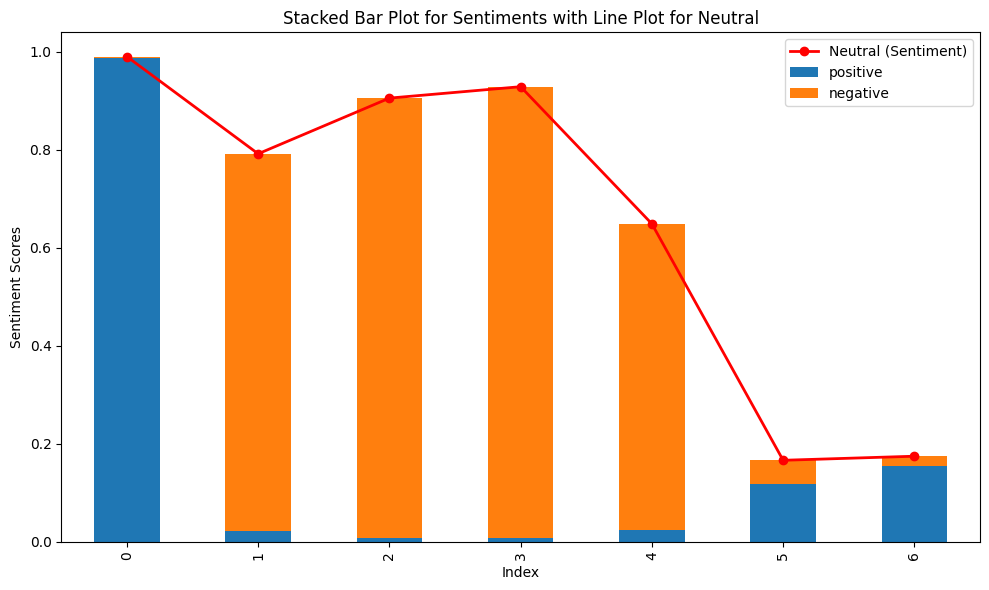

In [38]:
def plot_sentiment(input_df: pd.DataFrame,
                   keep_cols: list = None,
                   drop_cols: list = None,
                   neutral_col: str = None,
                   legend_out: bool = False):
    """
    Plots a stacked bar chart for selected sentiment columns and overlays a line plot for `1 - neutral`.
    
    Args:
        input_df (pd.DataFrame): DataFrame containing the sentiment data.
        keep_cols (list): List of columns to be included in the stacked bar 
        drop_cols (list): List of columns to be dropped. 
        neutral_col (str): Column name for the neutral sentiment (to plot 1 - neutral).
    
    Returns:
        None: Displays the plot.
    """
    # Stacked bar plot for the selected sentiment columns
    if keep_cols is None:
        keep_cols = input_df.columns.tolist()
    if drop_cols is None:
        drop_cols = []
    input_df[keep_cols].drop(columns=drop_cols).plot.bar(stacked=True,
                                                         figsize=(10, 6))

    # Line plot for `1 - neutral`
    if neutral_col is not None:
        plt.plot(input_df.index, 1 - input_df[neutral_col], color='red',
                 marker='o', label='Neutral (Sentiment)', linewidth=2)

    # Add legend and labels
    plt.legend(loc='best')
    plt.xlabel("Index")
    plt.ylabel("Sentiment Scores")
    plt.title("Stacked Bar Plot for Sentiments with Line Plot for Neutral")
    if legend_out:
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    # Show the plot
    plt.tight_layout()
    plt.show()


ngrams_list = recursive_text_splitter(sentence, 10, 5)
overlapping_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(overlapping_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Polarity per non overlapping sector

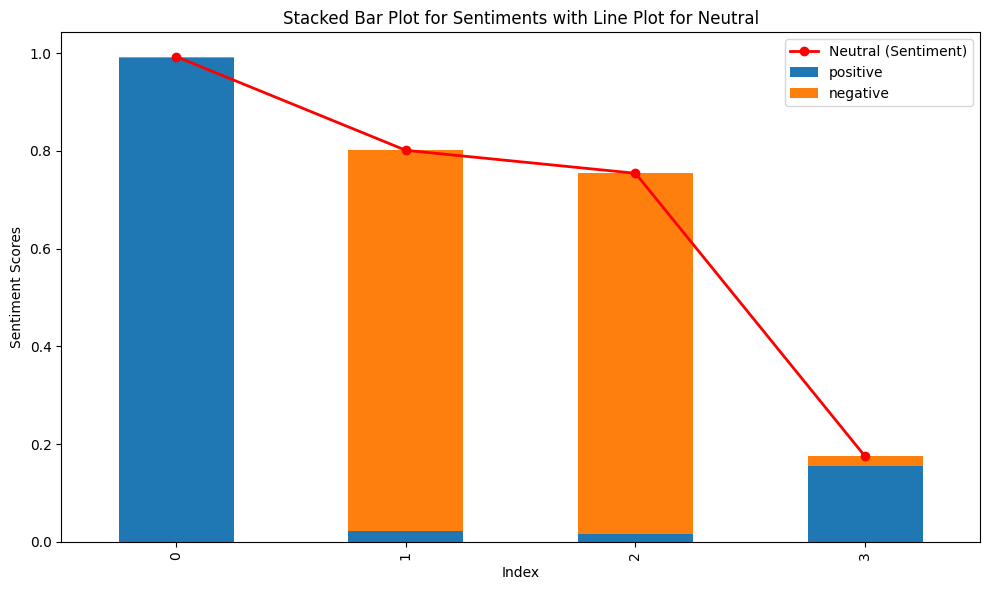

In [39]:
ngrams_list = recursive_text_splitter(sentence, 10, 0)
non_overlapping_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(non_overlapping_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Sentiments per overlapping sector

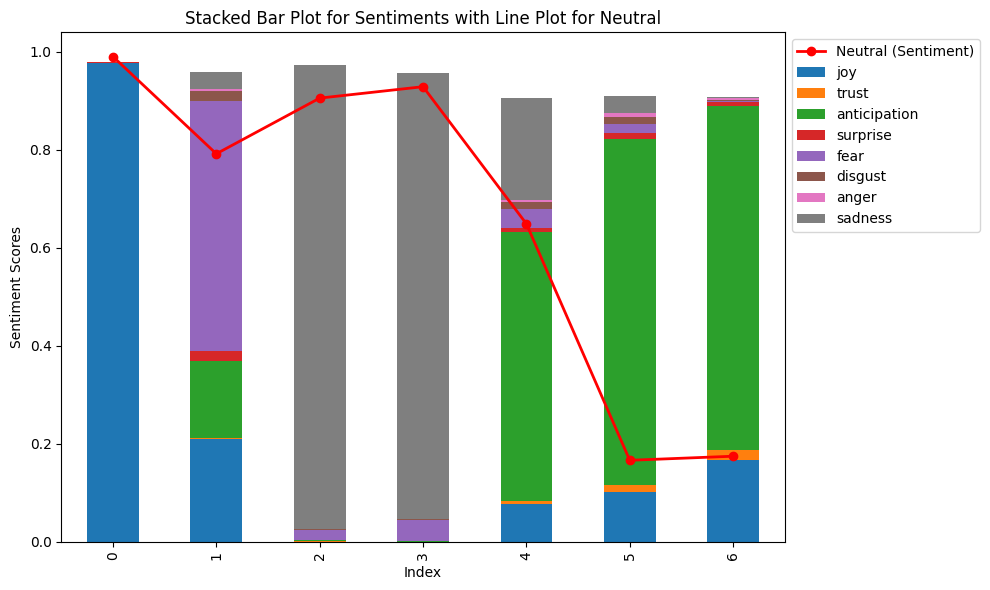

In [40]:
ngrams_list = recursive_text_splitter(sentence, 10, 5)
overlapping_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(overlapping_text_sample_df,
               drop_cols=["positive", "negative", "neutral", "love",
                          "pessimism", "optimism"],
               neutral_col="neutral",
               legend_out=True)



### Sentiment per word

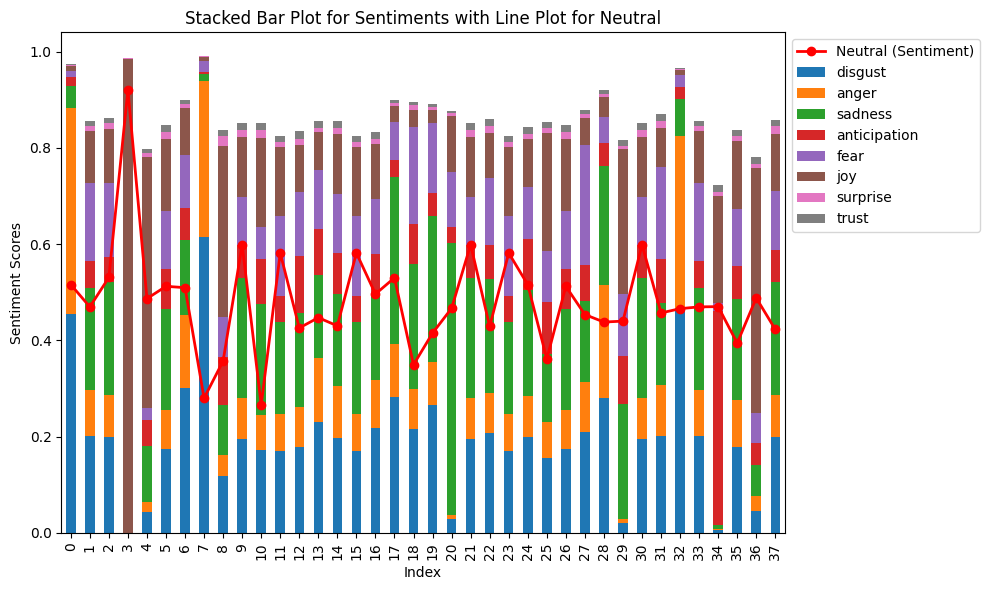

In [41]:
ngrams_list = word_tokenize(sentence)
overlapping_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(overlapping_text_sample_df,
               drop_cols=["positive", "negative", "neutral", "love",
                          "pessimism", "optimism"],
               neutral_col="neutral",
               legend_out=True)


### Polarity per word

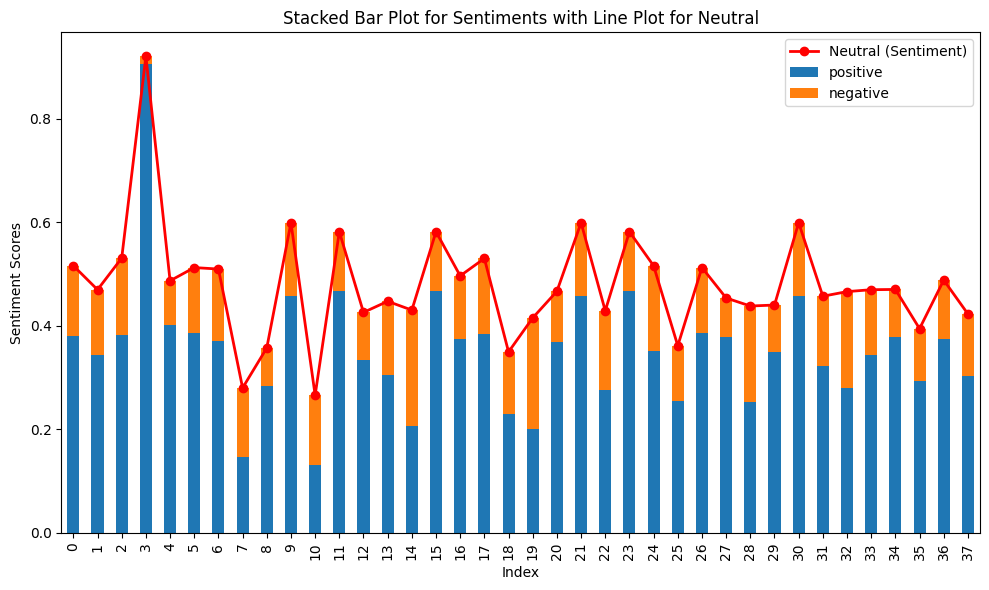

In [42]:
ngrams_list = word_tokenize(sentence)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

In [43]:
from nrclex import NRCLex
import nltk
nltk.download('wordnet')

text_words = word_tokenize(sentence)
text_object = NRCLex("/Users/Panos/Library/CloudStorage/Dropbox/PI_Squared/PycharmProjects/Research/NRCLex/nrc_en.json")
text_object.load_raw_text(sentence)

print(f"There are {len(text_object.affect_dict )} words in the "
      f"input text and the NRC: "
      f"{[key for key in text_object.affect_dict.keys()]}")


There are 2 words in the input text and the NRC: ['wonderful', 'prefer']


[nltk_data] Downloading package wordnet to /Users/Panos/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [44]:
get_feelings_for_words(text_object.affect_dict.keys()) 

,word,joy,optimism,love,surprise,trust,anticipation,sadness,fear,disgust,anger,pessimism,positive,neutral,negative
0,wonderful,0.9846,0.0130,0.0011,0.0007,0.0002,0.0002,0.0001,0.0001,0.0000,0.0000,0.000,0.9050,0.0796,0.0154
1,prefer,0.2450,0.0787,0.0185,0.0111,0.0129,0.1092,0.1402,0.1048,0.1554,0.0752,0.049,0.2542,0.6386,0.1072


In [45]:
text_object.affect_dict

{'wonderful': ['joy', 'positive', 'surprise', 'trust'],
 'prefer': ['positive', 'trust']}

In [46]:
text_object.top_emotions

[('trust', 0.3333333333333333), ('positive', 0.3333333333333333)]

In [47]:
get_word_feelings(sentence[50:])

{'word': 'ugh I can say that I do not feel very well, and I would prefer to stay at home, if this is okay with you.',
 'sadness': 0.8819,
 'fear': 0.046,
 'pessimism': 0.0412,
 'anticipation': 0.0181,
 'disgust': 0.0072,
 'anger': 0.0019,
 'surprise': 0.0011,
 'joy': 0.0011,
 'optimism': 0.0008,
 'trust': 0.0005,
 'love': 0.0002}

## TNLP with CMV
### Root argument

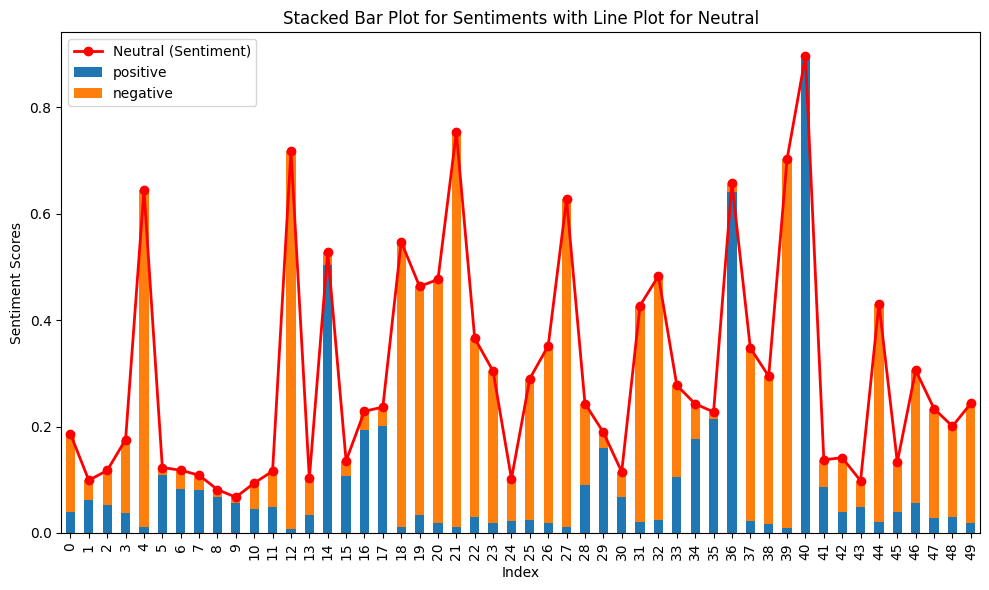

In [48]:
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Response 1 attacking the opinion of the root

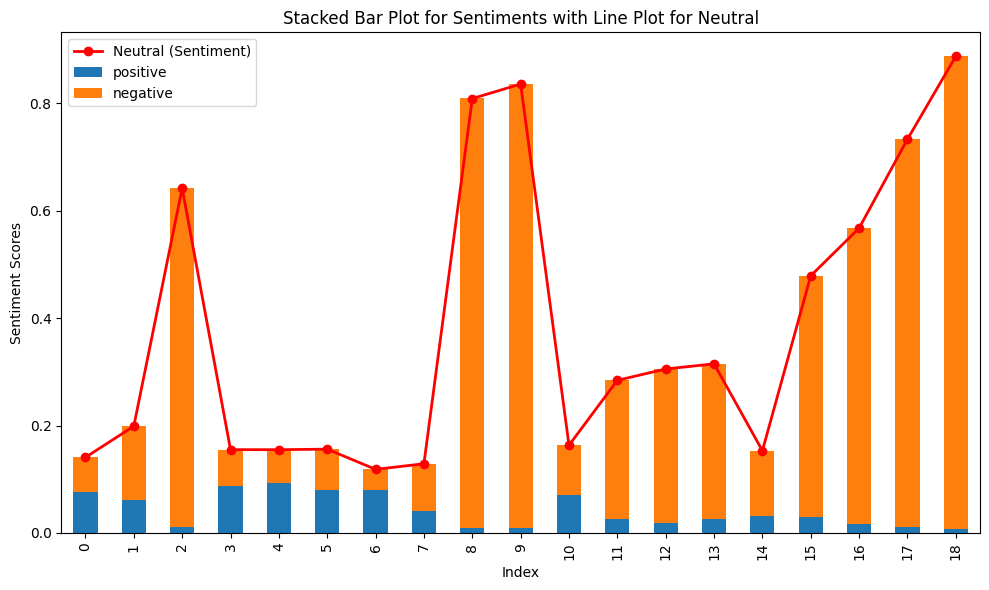

In [49]:
text = thread_df["text"][1]
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Response 2: The root responds to the attack


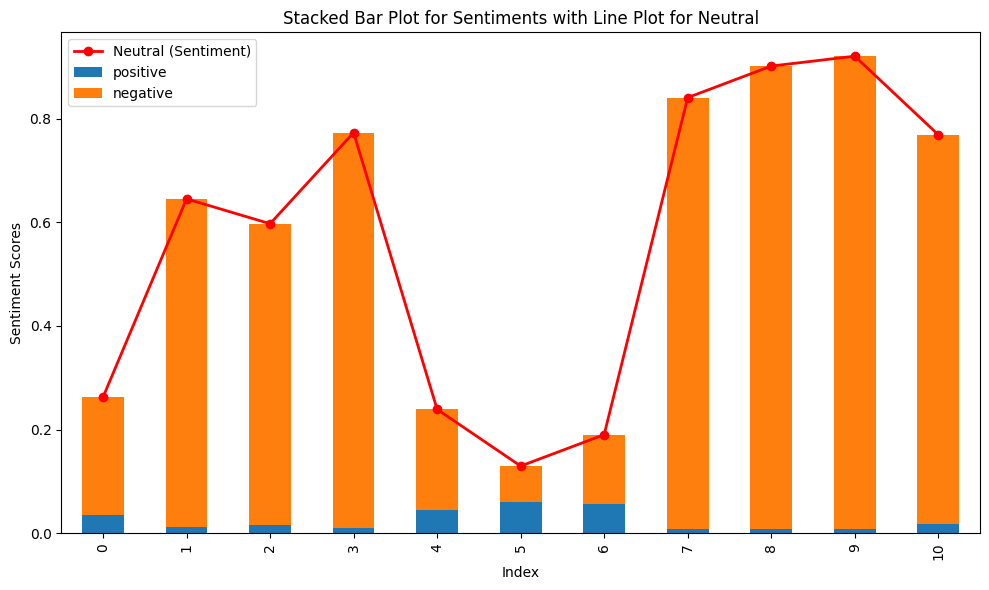

In [50]:
text = thread_df["text"][4]
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Response 3: counter attack against the root

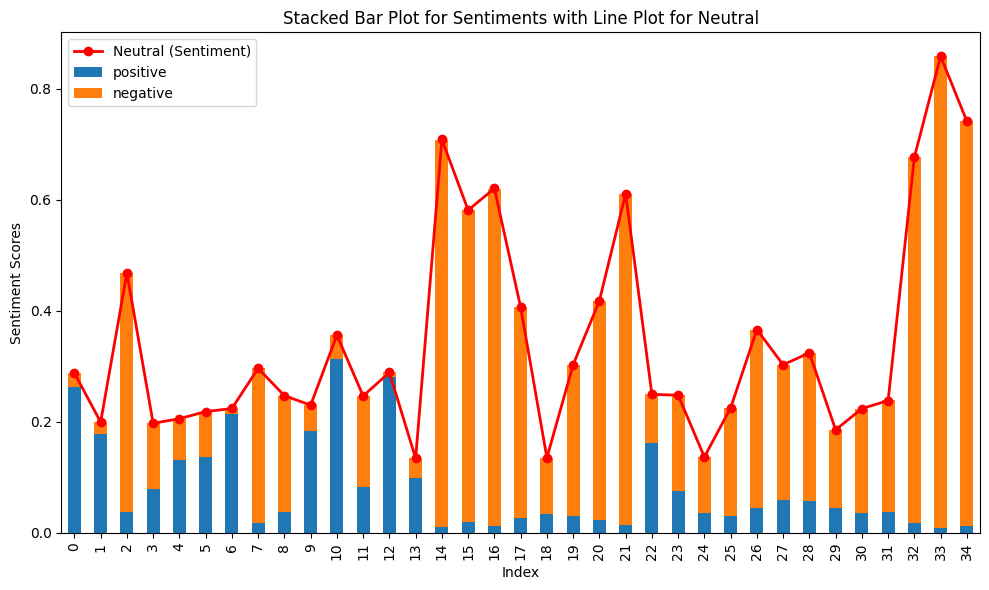

In [51]:
text = thread_df["text"][5]
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Response 4: root submits to the arguments of the attacker

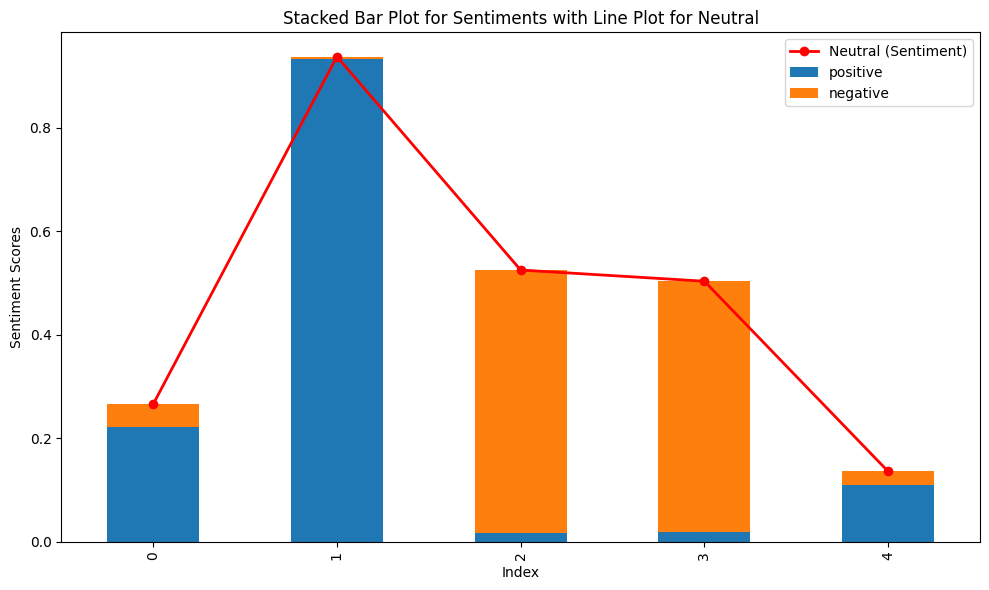

In [52]:
text = thread_df["text"][7]
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

### Example of direct aggrement with the root

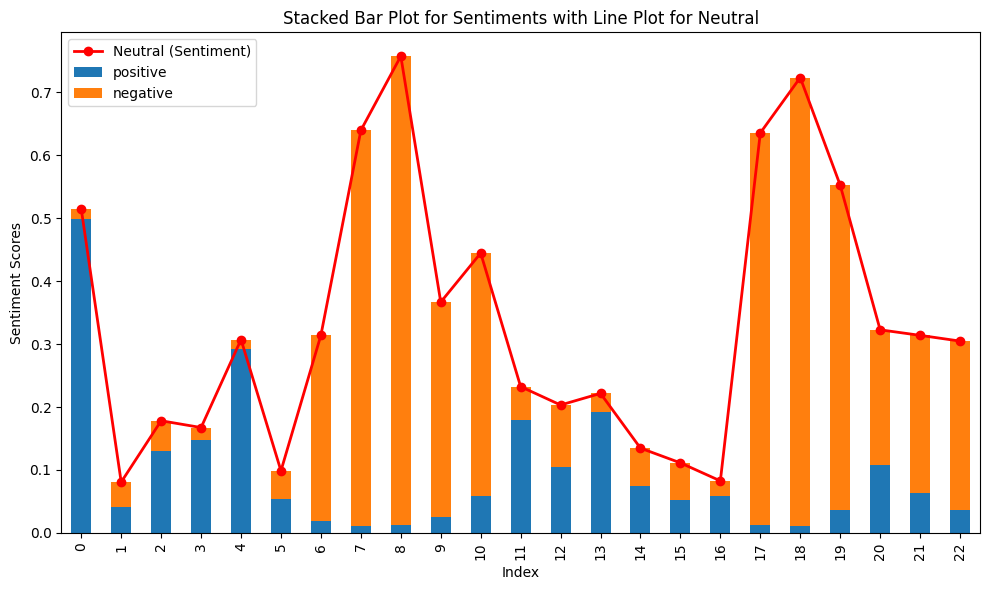

In [53]:
text = thread_df["text"][2]
ngrams_list = recursive_text_splitter(text, 10, 5)
word_text_sample_df = get_feelings_for_words(ngrams_list)
plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral")

In [54]:
thread_df[thread_df["success"]>0]

,utterance_id,speaker,reply_to,timestamp,text,success
1,t1_cnhplrm,Account9726,t3_2ro9ux,1420697092,"Look at the definition you provided, if we rem...",1
4,t1_cnhpsmr,seanyowens,t1_cnhplrm,1420697421,Maybe a new word is needed? Making such a dist...,1
16,t1_cnhrvq7,seanyowens,t1_cnhplrm,1420700886,∆. Yours was the first comment I read to make...,1


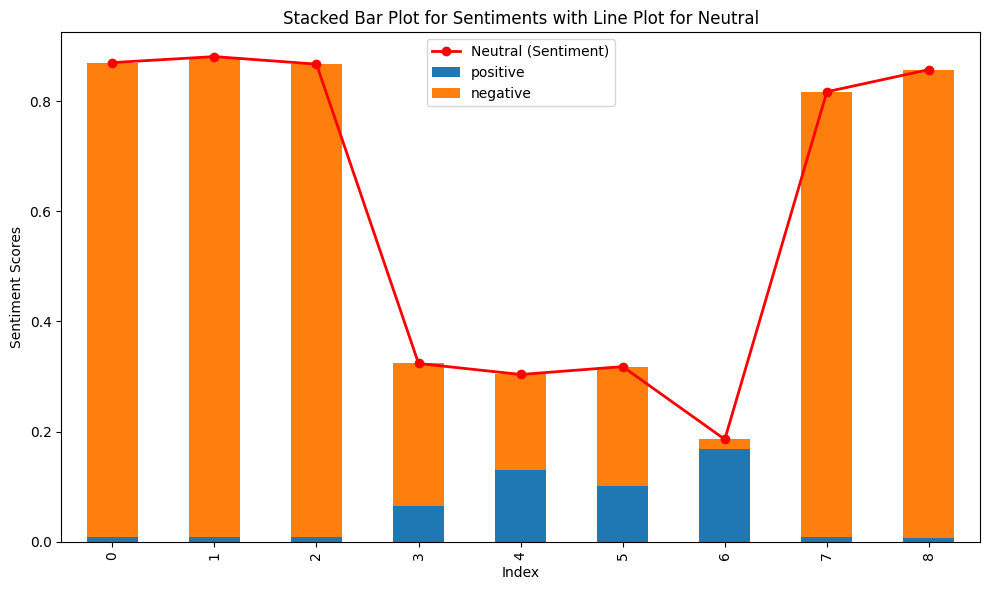

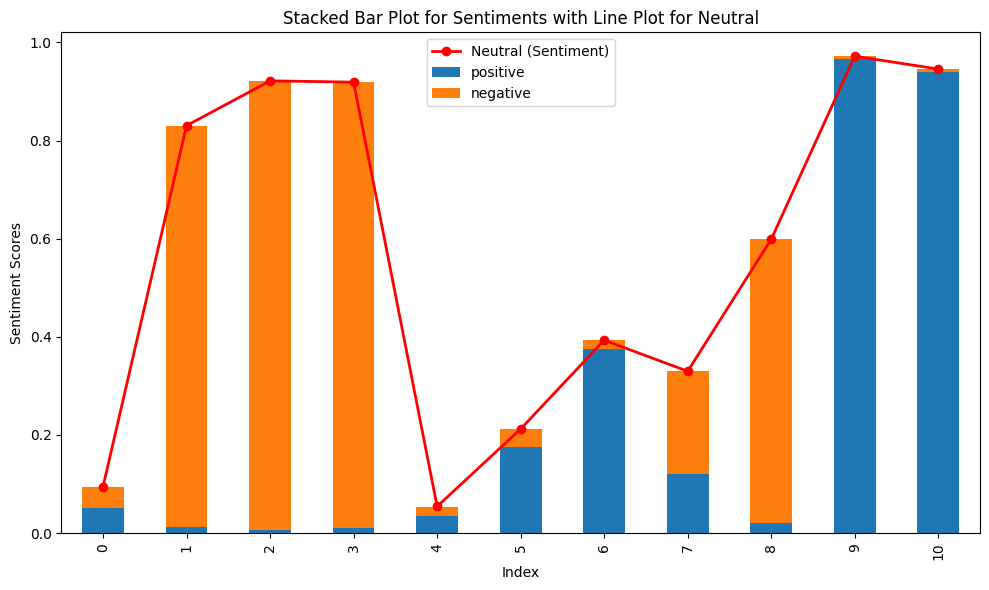

In [55]:
thread_df = get_thread(corpus, convos[8])
mind_changing_conv = thread_df[(thread_df["success"]>0) & 
                               (thread_df["speaker"]==thread_df["speaker"]
                                .iloc[0])]

for text in mind_changing_conv["text"]:
    ngrams_list = recursive_text_splitter(text, 10, 5)
    word_text_sample_df = get_feelings_for_words(ngrams_list)
    plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral") 

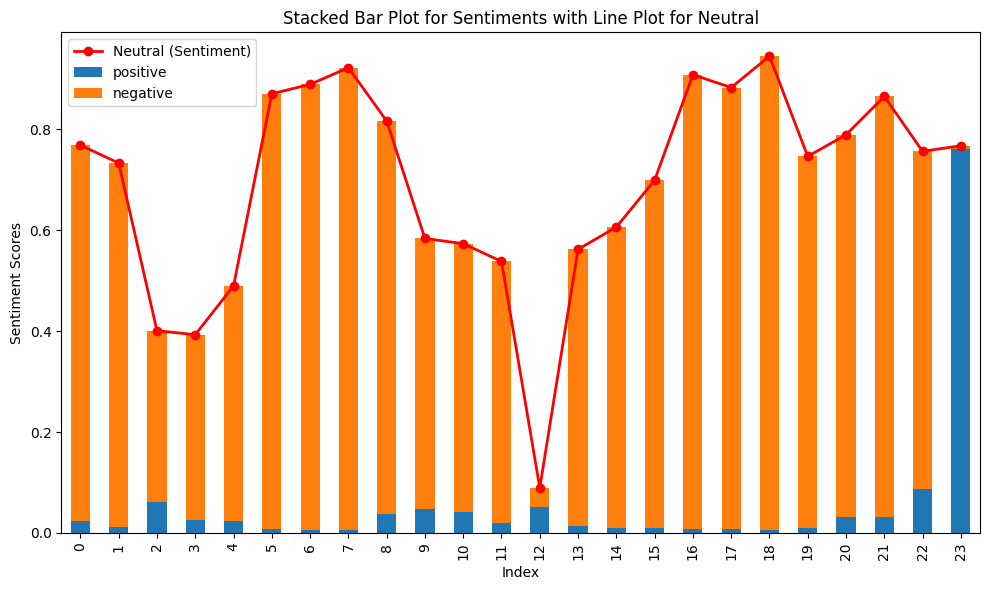

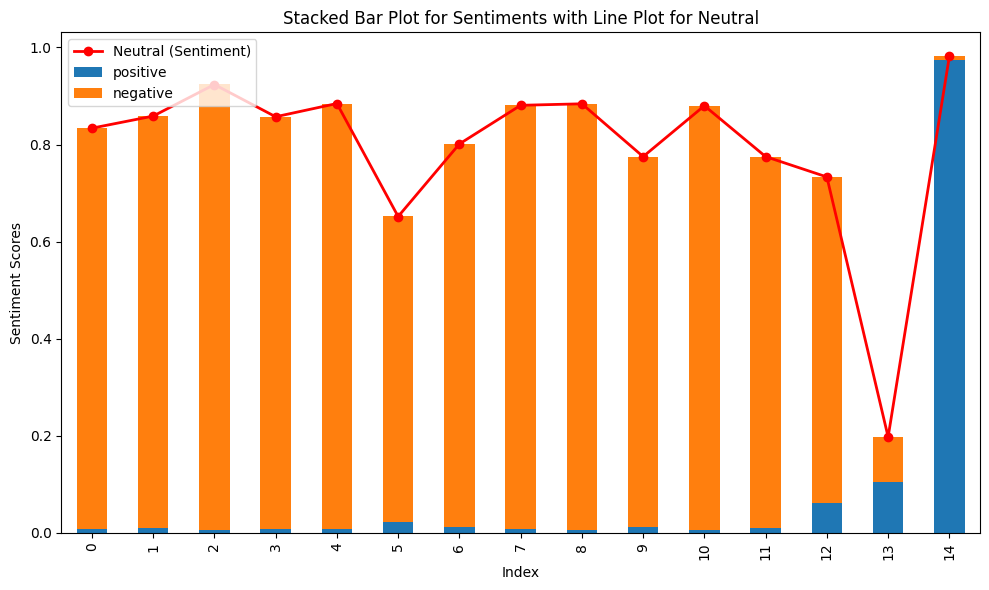

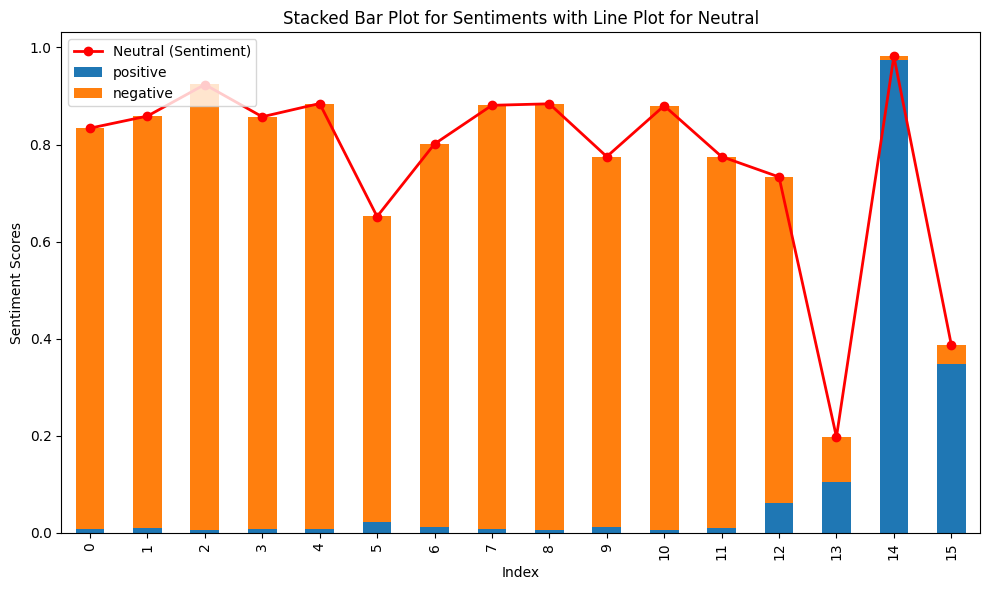

In [56]:
thread_df = get_thread(corpus, convos[5])
mind_changing_conv = thread_df[(thread_df["success"]>0) & 
                               (thread_df["speaker"]==thread_df["speaker"]
                                .iloc[0])]

for text in mind_changing_conv["text"]:
    ngrams_list = recursive_text_splitter(text, 10, 5)
    word_text_sample_df = get_feelings_for_words(ngrams_list)
    plot_sentiment(word_text_sample_df,
               keep_cols=["positive", "negative"],
               neutral_col="neutral") 

In [76]:
feelings_nrc = NRCLex("/Users/Panos/Library/CloudStorage/Dropbox/PI_Squared"
                      "/PycharmProjects/Research/NRCLex/nrc_v3.json")
feelings_nrc.load_raw_text(text)


In [80]:
text = thread_df["text"][0]
words_list = word_tokenize(' '.join(feelings_nrc.__lexicon__.keys()))
feelings_tnlc = get_feelings_for_words(words_list)

In [81]:
word = "freedom"
feelings_tnlc.loc[feelings_tnlc[feelings_tnlc['word'] == word].index[0], ["word", *feelings_nrc.affect_dict[word]]]

word     freedom
trust     0.0116
joy       0.3874
Name: 1755, dtype: object

In [83]:
feelings_tnlc.loc[feelings_tnlc[feelings_tnlc['word'] == word].index[0]]

word             bully
disgust          0.408
anger           0.5599
anticipation    0.0017
sadness         0.0211
joy             0.0029
optimism        0.0006
fear            0.0007
pessimism       0.0041
surprise        0.0004
trust           0.0002
love            0.0004
neutral         0.5238
positive        0.0982
negative         0.378
Name: 548, dtype: object

In [88]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
affect_dict = feelings_nrc.__lexicon__
new_df = pd.DataFrame(columns=feelings_tnlc.columns)
for word in affect_dict.keys():
    # word = lemmatizer.lemmatize(word)
    # print(word)
    row = [word] + [1 if value in affect_dict[word] else 0 for value in feelings_tnlc.columns[1:]]
    new_df.loc[len(new_df)] = row  
    

In [94]:
len(new_df)

4566

In [97]:
# Get matching rows using isin
unique_feelings_tnlc = feelings_tnlc.copy().drop_duplicates(subset=['word'], 
                                                      keep='first')
unique_feelings_tnlc['word_lemmatized'] = unique_feelings_tnlc['word']#.apply(lambda x: lemmatizer.lemmatize(x))
tnlc_copy_df = unique_feelings_tnlc[unique_feelings_tnlc['word_lemmatized'].isin(new_df['word'])]

In [91]:
unique_feelings_tnlc["word"].to_numpy()
#it seems that I have to find a solution for words that have similar meaning
# but are not identical like prophet and prophets 

array(['TRUE', 'abacus', 'abandon', ..., 'zeal', 'zealous', 'zest'],
      dtype=object)

In [92]:
tnlc_copy_df

,word,disgust,anger,anticipation,sadness,joy,optimism,fear,pessimism,surprise,trust,love,neutral,positive,negative,word_lemmatized
0,TRUE,0.2537,0.2384,0.1585,0.0976,0.0964,0.0433,0.0324,0.0307,0.0243,0.0135,0.0114,0.6315,0.2177,0.1508,TRUE
1,abacus,0.3240,0.1381,0.0753,0.1372,0.0607,0.0279,0.1588,0.0507,0.0134,0.0069,0.0070,0.7252,0.1607,0.1141,abacus
2,abandon,0.1800,0.0920,0.0051,0.6888,0.0024,0.0009,0.0028,0.0256,0.0013,0.0005,0.0006,0.7941,0.1106,0.0953,abandon
3,abandoned,0.0179,0.0096,0.0005,0.9572,0.0003,0.0002,0.0007,0.0131,0.0002,0.0001,0.0002,0.6270,0.0514,0.3216,abandoned
4,abandonment,0.0198,0.0066,0.0015,0.9452,0.0017,0.0006,0.0009,0.0224,0.0005,0.0003,0.0005,0.5764,0.0489,0.3747,abandonment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4561,youth,0.1348,0.0337,0.1360,0.2487,0.1710,0.0788,0.0757,0.0773,0.0168,0.0143,0.0130,0.6909,0.2075,0.1016,youth
4562,zany,0.1014,0.0366,0.0589,0.2060,0.3843,0.0641,0.0723,0.0415,0.0114,0.0086,0.0150,0.7451,0.1751,0.0797,zany
4563,zeal,0.2047,0.0764,0.0697,0.2179,0.1886,0.0506,0.0986,0.0583,0.0139,0.0091,0.0121,0.7003,0.2297,0.0700,zeal
4564,zealous,0.2509,0.3522,0.0396,0.0503,0.0126,0.0230,0.2297,0.0353,0.0018,0.0032,0.0014,0.5287,0.1402,0.3311,zealous


### Compare NRC and TNLP feelings

Comparing the binary lexicon (NLC) with the continuous feeling values (TNLP).


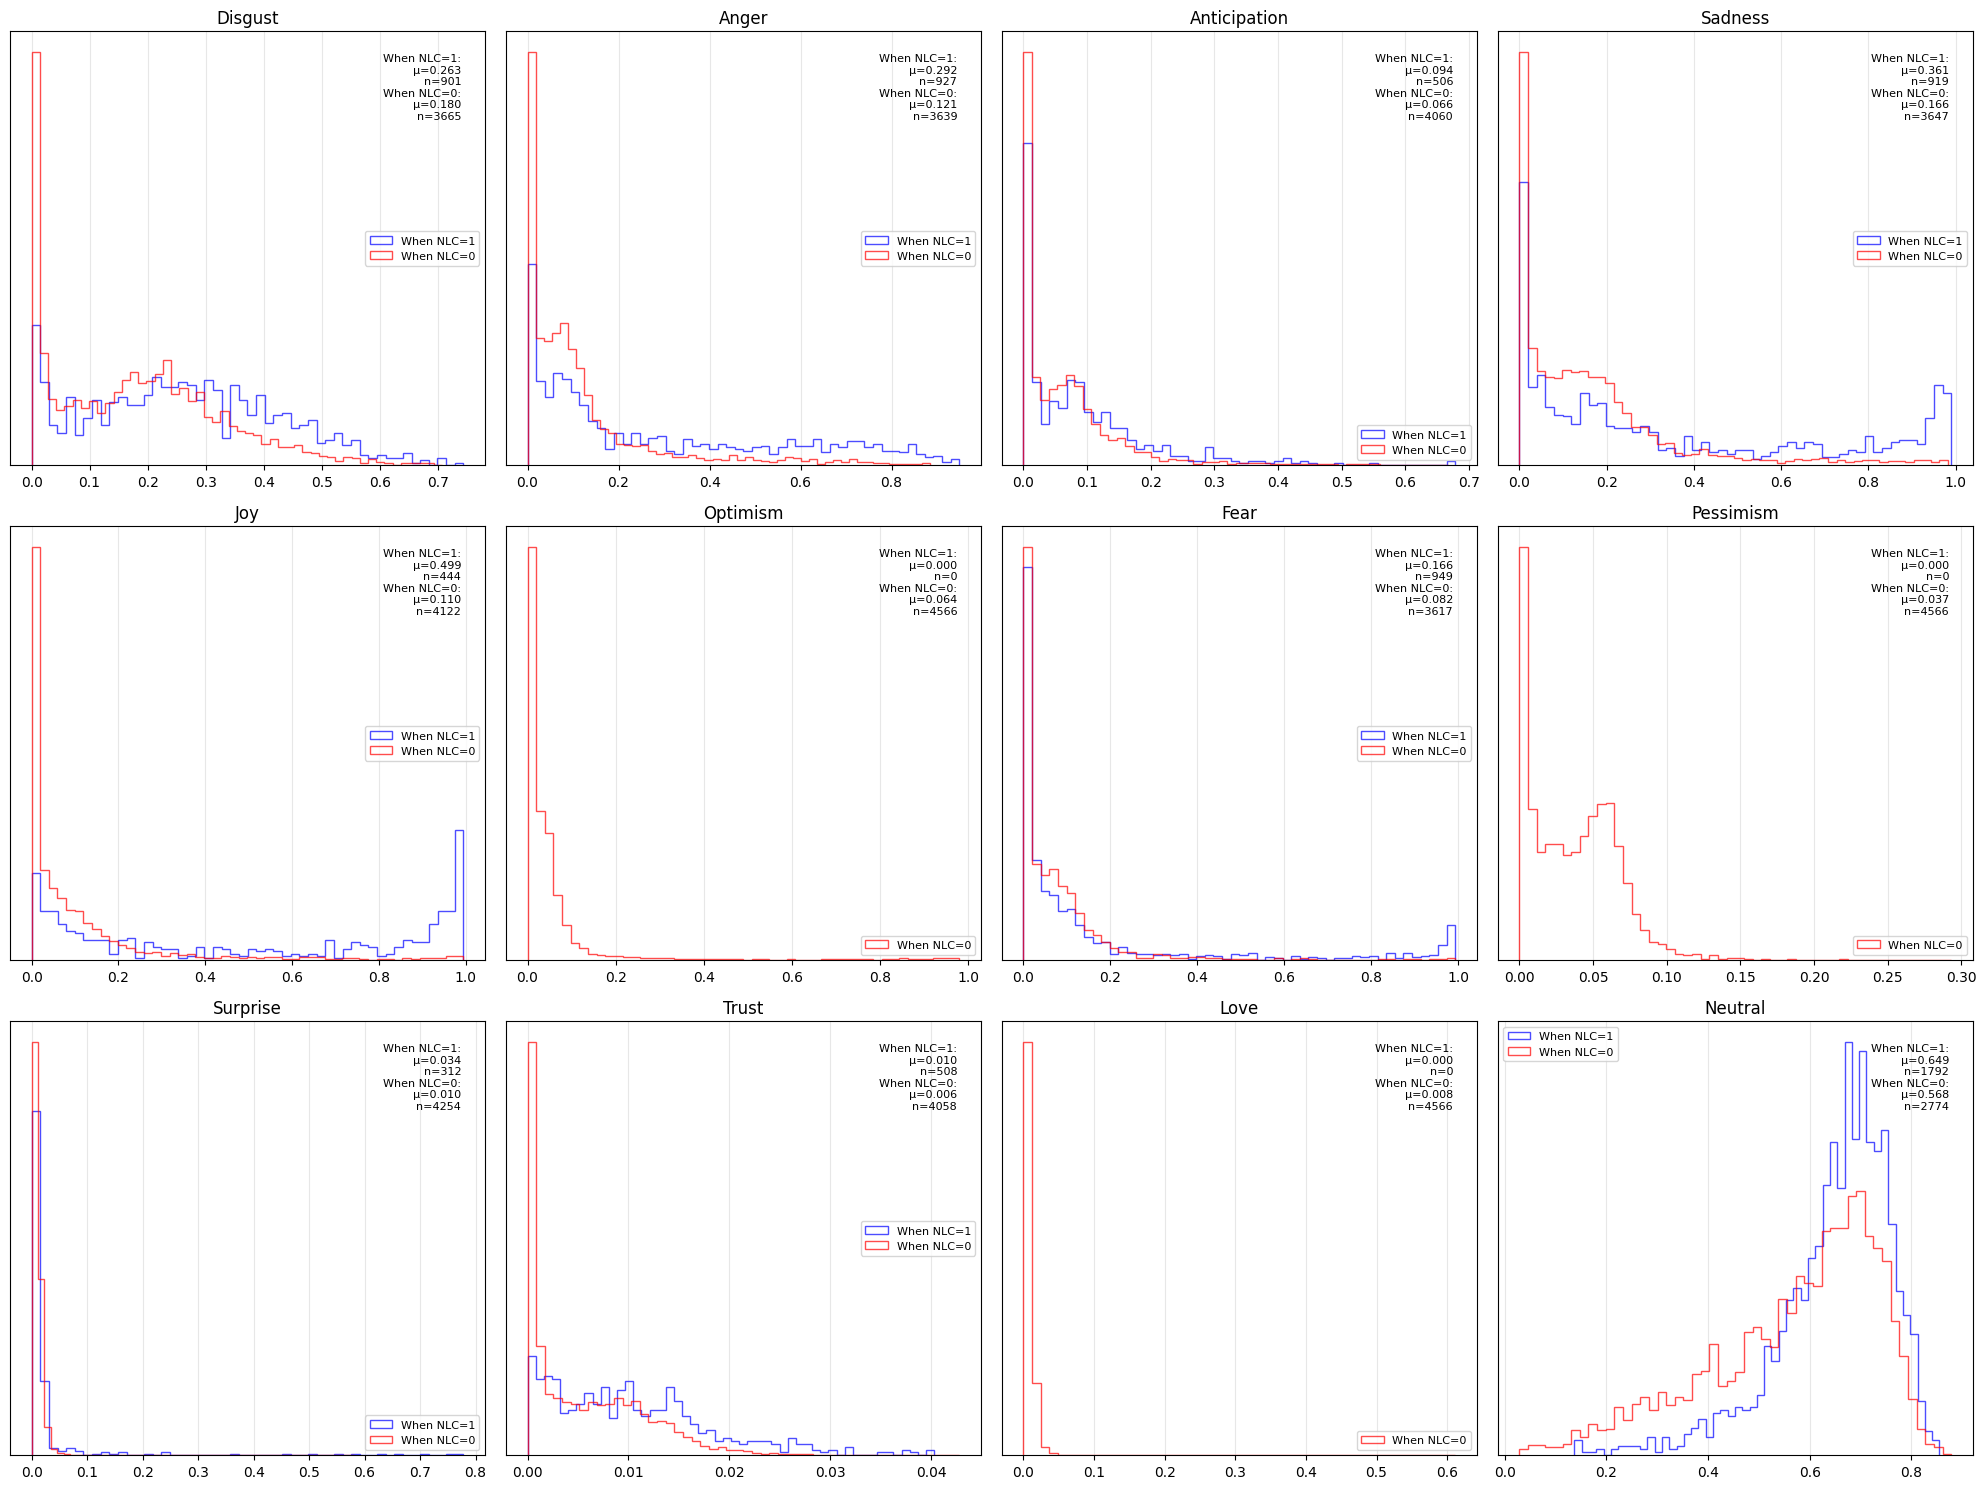

In [113]:
import numpy as np
import matplotlib.pyplot as plt

def analyze_lexicon_comparison(nlc_df, tnlp_df, feeling):
    """
    Compare TNLP scores based on NLC lexicon binary classification.
    
    Args:
        nlc_df: DataFrame with binary NLC lexicon values (0 or 1)
        tnlp_df: DataFrame with continuous TNLP scores
        feeling: The feeling to analyze
        
    Returns:
        dict: Contains scores where NLC indicates presence vs absence
    """
    # Get binary indicators and continuous scores
    nlc_binary = nlc_df[feeling].to_numpy()
    tnlp_scores = tnlp_df[feeling].to_numpy()
    
    # Separate TNLP scores based on NLC classification
    scores_when_present = tnlp_scores[nlc_binary == 1]  # When NLC indicates feeling
    scores_when_absent = tnlp_scores[nlc_binary == 0]   # When NLC indicates no feeling
    
    # Calculate statistics
    stats = {
        'present': {
            'mean': np.mean(scores_when_present) if len(scores_when_present) > 0 else 0,
            'std': np.std(scores_when_present) if len(scores_when_present) > 0 else 0,
            'count': len(scores_when_present),
            'scores': scores_when_present
        },
        'absent': {
            'mean': np.mean(scores_when_absent) if len(scores_when_absent) > 0 else 0,
            'std': np.std(scores_when_absent) if len(scores_when_absent) > 0 else 0,
            'count': len(scores_when_absent),
            'scores': scores_when_absent
        }
    }
    
    return stats

def plot_lexicon_comparison(nlc_df, tnlp_df, feelings=None, figsize=(20, 15)):
    """
    Plot comparison for all feelings.
    """
    if feelings is None:
        feelings = nlc_df.columns[1:]  # Assuming first column is not a feeling
        
    fig, axes = plt.subplots(3, 4, figsize=figsize)
    axes_flat = axes.flatten()
    
    for idx, feeling in enumerate(feelings):
        if idx >= 12:  # Skip if more than 12 feelings
            break
            
        ax = axes_flat[idx]
        stats = analyze_lexicon_comparison(nlc_df, tnlp_df, feeling)
        
        # Plot distributions
        if len(stats['present']['scores']) > 0:
            ax.hist(stats['present']['scores'], bins=50, density=True,
                   histtype="step", label='When NLC=1', color='blue', alpha=0.7)
        if len(stats['absent']['scores']) > 0:
            ax.hist(stats['absent']['scores'], bins=50, density=True,
                   histtype="step", label='When NLC=0', color='red', alpha=0.7)
        
        # Add statistics
        stat_text = (
            f"When NLC=1:\n"
            f"  μ={stats['present']['mean']:.3f}\n"
            f"  n={stats['present']['count']}\n"
            f"When NLC=0:\n"
            f"  μ={stats['absent']['mean']:.3f}\n"
            f"  n={stats['absent']['count']}"
        )
        
        ax.text(0.95, 0.95, stat_text,
                transform=ax.transAxes,
                verticalalignment='top',
                horizontalalignment='right',
                fontsize=8)
        
        ax.set_title(feeling.capitalize())
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)
        ax.set_yticks([])
    
    # Remove empty subplots
    if len(feelings) < 12:
        for idx in range(len(feelings), 12):
            fig.delaxes(axes_flat[idx])
    
    plt.tight_layout()
    return fig, axes

# Usage example:
fig, axes = plot_lexicon_comparison(new_df, tnlc_copy_df)
plt.show()

Transform and save the lexicon from csv to json

In [73]:
import pandas as pd
import json

df = pd.read_csv('../NRCLex/nrcv3.csv', names=['pos', 'word', 'emotions'])
df['emotions'] = df['emotions'].str.split('|')
word_emotions = df.groupby('word')['emotions'].agg(lambda x: list(set([item for sublist in x for item in sublist])))
emotions_dict = word_emotions.to_dict()
with open('nrc_v3.json', 'w') as f:
    json.dump(emotions_dict, f, indent=4)

In [85]:
feelings_nrc.__lexicon__

{'TRUE': ['neutral', 'trust'],
 'abacus': ['neutral'],
 'abandon': ['sadness', 'fear'],
 'abandoned': ['sadness', 'fear'],
 'abandonment': ['sadness', 'fear'],
 'abbot': ['neutral'],
 'abduction': ['sadness', 'fear', 'surprise'],
 'aberration': ['disgust'],
 'abhor': ['anger', 'disgust'],
 'abhorrent': ['anger', 'disgust'],
 'abject': ['disgust'],
 'abnormal': ['disgust'],
 'abolish': ['neutral'],
 'abominable': ['disgust', 'fear'],
 'abomination': ['anger', 'fear', 'disgust'],
 'abortion': ['disgust', 'fear', 'sadness'],
 'abortive': ['sadness'],
 'abrupt': ['surprise'],
 'abscess': ['neutral'],
 'absence': ['neutral'],
 'absent': ['neutral'],
 'absentee': ['neutral'],
 'absolution': ['trust', 'joy'],
 'abundance': ['neutral'],
 'abundant': ['neutral'],
 'abuse': ['anger', 'fear', 'disgust', 'sadness'],
 'abysmal': ['neutral'],
 'abyss': ['neutral'],
 'academic': ['neutral'],
 'accelerate': ['anticipation'],
 'accident': ['sadness', 'fear', 'surprise'],
 'accidental': ['neutral', 'fea

In [86]:
affect_dict

{'happen': ['anticipation'],
 'freedom': ['trust', 'joy'],
 'shooting': ['anger', 'fear'],
 'line': ['neutral'],
 'offensive': ['anger', 'disgust'],
 'prophet': ['anticipation'],
 'leader': ['trust'],
 'bad': ['disgust', 'neutral', 'sadness'],
 'bully': ['anger', 'fear', 'joy', 'surprise']}